# Libraries

In [1]:
from operator import itemgetter
from tqdm import tqdm
import time
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.autograd import Variable

# Directories

In [2]:
wtd_csv_path = "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv"
meteo_nc_path = "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc"
wtd_stations_shp_path = "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp"
dtm_nc_path = "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc"

# Dataset class

In [3]:

class ContinuousDataset(Dataset):
    """Weather and WTD Dataset for the continuous case model"""

    def __init__(self, dict_files, #meteo_nc_path, wtd_csv_path, wtd_stations_shp_path,
                 fill_value = 0,
                 transform = None):
        """
        Args:
            dict_files (string): Path to the .nc file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        
        # Attributes init
        self.dict_files = dict_files
        self.timesteps = self.dict_files["timesteps"]

        # Meteorological data loading 
        self.loading_weather()
        
        # Digital Terrain Model data loading
        self.loading_dtm()
        
        # Water Table Depth data loading 
        self.loading_point_wtd(fill_value = fill_value)

        # Transform       
        self.transform = transform
        
    def loading_dtm(self):
        self.dtm_roi = rioxarray.open_rasterio(self.dict_files["dtm_nc"],
                                               engine='fiona')
        self.dtm_roi = self.dtm_roi.rio.write_crs("epsg:4326")
        
            
    def loading_weather(self):
        self.weather_xr = xarray.open_dataset(self.dict_files["weather_nc_path"])
        self.weather_xr = self.weather_xr.rio.write_crs("epsg:4326")
        
        # Compute coord matrix
        lat_matrix = np.vstack([self.weather_xr.lat.values for i in range(len(self.weather_xr.lon.values))]).transpose()
        lon_matrix = np.vstack([self.weather_xr.lon.values for i in range(len(self.weather_xr.lat.values))])
        self.weather_coords = np.stack([lat_matrix,lon_matrix], axis = -1)
        

    def loading_point_wtd(self, fill_value = 0):
        
        # Water Table Depth data loading
        self.wtd_df = pd.read_csv(self.dict_files["wtd_csv_path"], 
                                    dtype= {"sensor_id": "str"})
        self.wtd_df = self.wtd_df.astype({"date":'datetime64[ns]'})

        # Water Table Depth Sensors shapefile loading: 
        self.wtd_names = gpd.read_file(self.dict_files["wtd_shp"],
                                             engine='fiona')
        self.wtd_names = self.wtd_names.to_crs('epsg:4326')

        # Define attributes about dates and coordinates
        self.dates = self.wtd_df["date"].unique()
        self.sensor_id_list = self.wtd_df["sensor_id"].unique()
        
        
        ### Merge csv and shp into a joint spatio temporal representation
        sensor_coord_x_list = []
        sensor_coord_y_list = []

        # Retrieve coordinates from id codes
        for sensor in self.sensor_id_list:
            coord_x = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.x.values[0]
            coord_y = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.y.values[0]
            sensor_coord_x_list.append(coord_x)
            sensor_coord_y_list.append(coord_y)

        # Buil a dictionary of coordinates and id codes
        from_id_to_coord_x_dict = {self.sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
        from_id_to_coord_y_dict = {self.sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

        # Map id codes to coordinates for all rows in the original ds
        queries = list(self.wtd_df["sensor_id"].values)
        coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
        coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

        # insert new columns containing coordinates
        self.wtd_df["x"] = coordinates_x
        self.wtd_df["y"] = coordinates_y
        
        self.wtd_df = self.wtd_df.set_index(["date","y","x"])
        
        # Subset wtd data truncating the last `timestep` instances
        last_date = self.dates.max() - np.timedelta64(self.timesteps, 'D')
        self.input_dates = self.dates[self.dates <= last_date]
        
        # Create nan-mask
        self.wtd_df["nan_mask"] = 1*~self.wtd_df["wtd"].isna()
        self.wtd_df["wtd"] = self.wtd_df["wtd"].fillna(fill_value)
        
    def __len__(self):
        data = self.wtd_df.loc[pd.IndexSlice[self.wtd_df.index.get_level_values(0) <= self.input_dates.max(),
                                                       :,
                                                       :]]
        return len(data)
    
    def __getitem__(self, idx):
        
        if idx < 0:
            idx = self.__len__() + idx
        
        # Retrieve date and coords for idx instance
        start_date = self.wtd_df.iloc[idx, :].name[0]
        sample_lat = self.wtd_df.iloc[idx, :].name[1]
        sample_lon = self.wtd_df.iloc[idx, :].name[2]
        sample_dtm = self.dtm_roi.sel(x = sample_lon,
                                      y = sample_lat,
                                      method = "nearest").values  
        
        end_date = start_date + np.timedelta64(self.timesteps, "D")
        
        # print("start date: ", str(start_date))
        # print("end date: ", str(end_date))
        
        # Initial state WTD (t0) data
        wtd_t0 = self.wtd_df[["wtd", "nan_mask"]].loc[self.wtd_df.index.get_level_values(0) == start_date]
        wtd_t0_values = wtd_t0["wtd"].values
        wtd_t0_mask = wtd_t0["nan_mask"].values
        wtd_t0_lat = wtd_t0.index.get_level_values(1).values
        wtd_t0_lon = wtd_t0.index.get_level_values(2).values
        wtd_t0_dtm = np.array([self.dtm_roi.sel(x = wtd_t0_lon[sensor],
                                                y = wtd_t0_lat[sensor],
                                                method = "nearest") for sensor in range(len(wtd_t0_lat))]).squeeze()
        
        #wtd_t0_mask = 1*~np.isnan(wtd_t0_values)
        X = [torch.from_numpy(wtd_t0_lat).to(torch.float32),
             torch.from_numpy(wtd_t0_lon).to(torch.float32),
             torch.from_numpy(wtd_t0_dtm).to(torch.float32),
             torch.from_numpy(wtd_t0_values).to(torch.float32),
             torch.from_numpy(wtd_t0_mask).to(torch.float32)]
        X = torch.stack(X, dim = -1)
        
        Z = [torch.tensor(sample_lat).reshape(1).to(torch.float32),
             torch.tensor(sample_lon).reshape(1).to(torch.float32),
             torch.tensor(sample_dtm).reshape(1).to(torch.float32)]
        
        Z = torch.stack(Z, dim = -1)
        
        # Retrieve weather data
        weather_video = self.weather_xr.sel(time = slice(start_date + np.timedelta64(1, "D"),
                                                    end_date)) #slice include extremes
        weather_video = weather_video.to_array().values
        W = [torch.from_numpy(weather_video).to(torch.float32),
             torch.from_numpy(self.weather_coords).to(torch.float32)]
        
        # Retrieve wtd values from t0+1 to T for the idx instance sensor
        wtd_t1_T = self.wtd_df[["wtd", "nan_mask"]].loc[(self.wtd_df.index.get_level_values(0) > start_date) &
                                          (self.wtd_df.index.get_level_values(0) <= end_date)  & 
                                          (self.wtd_df.index.get_level_values(1) == sample_lat)&
                                          (self.wtd_df.index.get_level_values(2) == sample_lon)]
        
        wtd_t1_T_values =  wtd_t1_T["wtd"].values
        wtd_t1_T_mask =  wtd_t1_T["nan_mask"].values        
        
        Y = [torch.from_numpy(wtd_t1_T_values).to(torch.float32),
             torch.from_numpy(wtd_t1_T_mask).to(torch.float32)]
        
        Y = torch.stack(Y, dim = -1)
        
        if self.transform:
            sample = self.transform(sample)
        
        return [X, Z, W, Y]

In [4]:
dict_files = {
    "wtd_csv_path" : "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv",
    "weather_nc_path" : "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc",
    "wtd_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp",
    "piedmont_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp",
    "dtm_nc" : "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc",
    "timesteps" : 180
}

ds = ContinuousDataset(dict_files)

In [5]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 311457


## Test

In [6]:
sample = -1
start_date = np.datetime64("2023-07-04 00:00:00")
end_date = np.datetime64("2023-12-31 00:00:00")
test_getitem_ds = ds[sample]

In [7]:
test_getitem_ds[3].shape

torch.Size([180, 2])

In [8]:
test_getitem_ds[2][0].shape

torch.Size([10, 180, 9, 12])

In [9]:
x = torch.tensor([[10,5,4],
                  [1,8,9]])
print(x)
y = torch.tensor([[True,False,False],
                  [True,False,True]])
print(y)
#torch.where(x > 0)

tensor([[10,  5,  4],
        [ 1,  8,  9]])
tensor([[ True, False, False],
        [ True, False,  True]])


In [10]:
torch.masked_select(x, y)

tensor([10,  1,  9])

In [11]:
test_getitem_ds[2][1][:,:,0]

tensor([[45.3130, 45.3130, 45.3130, 45.3130, 45.3130, 45.3130, 45.3130, 45.3130,
         45.3130, 45.3130, 45.3130, 45.3130],
        [45.1880, 45.1880, 45.1880, 45.1880, 45.1880, 45.1880, 45.1880, 45.1880,
         45.1880, 45.1880, 45.1880, 45.1880],
        [45.0630, 45.0630, 45.0630, 45.0630, 45.0630, 45.0630, 45.0630, 45.0630,
         45.0630, 45.0630, 45.0630, 45.0630],
        [44.9380, 44.9380, 44.9380, 44.9380, 44.9380, 44.9380, 44.9380, 44.9380,
         44.9380, 44.9380, 44.9380, 44.9380],
        [44.8130, 44.8130, 44.8130, 44.8130, 44.8130, 44.8130, 44.8130, 44.8130,
         44.8130, 44.8130, 44.8130, 44.8130],
        [44.6880, 44.6880, 44.6880, 44.6880, 44.6880, 44.6880, 44.6880, 44.6880,
         44.6880, 44.6880, 44.6880, 44.6880],
        [44.5630, 44.5630, 44.5630, 44.5630, 44.5630, 44.5630, 44.5630, 44.5630,
         44.5630, 44.5630, 44.5630, 44.5630],
        [44.4380, 44.4380, 44.4380, 44.4380, 44.4380, 44.4380, 44.4380, 44.4380,
         44.4380, 44.4380, 44.

# Model 

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class Continuous1DNN(nn.Module):
    def __init__(self, num_layers = 1,
                 num_sensor = 31,
                 height = 9,
                 width = 12,
                 lstm_layer = 1):
        super().__init__()
        
        # Conditioning block - gate fashion        
        # Values embedding
        cb_vemb = []
        cb_vemb.append(nn.Linear(2, 1))
        cb_vemb.append(nn.ReLU())
        self.cb_vemb = nn.Sequential(*cb_vemb)
        # Coordinates embedding
        cb_cemb = []
        cb_cemb.append(nn.Linear(3, 1))
        cb_cemb.append(nn.ReLU())
        self.cb_cemb = nn.Sequential(*cb_cemb)
        
        self.cb_softmax = nn.Softmax(dim = 1)
        # Fully connected
        cb_fc = []
        cb_fc.append(nn.Linear(num_sensor, 1))
        cb_fc.append(nn.ReLU())
        self.cb_fc = nn.Sequential(*cb_fc)
        
        # Weather block
        conv3d_stack=[]
        conv3d_stack.append(nn.Conv3d(12, 8, (1,2,2))) # Conv input (N, C, D, H, W) - kernel 3d (D, H, W)
        #self.conv3d_stack.append(nn.BatchNorm3d)
        conv3d_stack.append(nn.ReLU())
        
        for i in range(4):
            conv3d_stack.append(nn.Conv3d(8, 8, (1,2,2)))
            #self.conv3d_stack.append(nn.BatchNorm3d)
            conv3d_stack.append(nn.ReLU())
            
        conv3d_stack.append(nn.AdaptiveAvgPool3d((None,4,4)))
        conv3d_stack.append(nn.Conv3d(8, 8, (1,2,2)))
        conv3d_stack.append(nn.ReLU())
        conv3d_stack.append(nn.Conv3d(8, 8, (1,2,2)))
        conv3d_stack.append(nn.ReLU())
        conv3d_stack.append(nn.Conv3d(8, 8, (1,2,2)))
        conv3d_stack.append(nn.ReLU())
        self.conv3d_stack = nn.Sequential(*conv3d_stack)
            
        # Joint sequental block
        self.lstm_1 = nn.LSTM(8, 16, batch_first=True,
                              num_layers=lstm_layer) # Batch first input (N,L,H)
        
        fc = []
        fc.append(nn.Linear(16, 8))
        fc.append(nn.ReLU())
        fc.append(nn.Linear(8, 1))
        self.fc = nn.Sequential(*fc)


    def forward(self, x, z, w):
        """
        input : x (31, 5); z (1, 3); w[0] (10, 180, 9, 12); w[1] (9, 12, 2)
        return 
            lstm_out (array): lstm_out = [S_we, M, P_r, Es, K_s, K_r]
        x: tensor of shape (L,Hin) if minibatches itaration (L,N,Hin) when batch_first=False (default)
        """
        
        # #x (31, 5); z (1, 3); w[0] (10, 180, 9, 12); w[1] (9, 12, 2); y (180, 2)
        # [wtd_t0_lat, wtd_t0_lon,
        #  wtd_t0_dtm, wtd_t0_values,
        #  wtd_t0_mask] = x
        
        # [sample_lat, sample_lon, sample_dtm] = z
        
        
        # Conditioning block
        cb_value_emb = self.cb_vemb(x[:,:,3:])
        
        cb_coord_emb = torch.cat((x[:,:,:3], z), dim = 1)
        cb_coord_emb = self.cb_cemb(cb_coord_emb)
        cb_coord_emb_s = cb_coord_emb[:,:x[:,:,:3].shape[1],:]
        cb_coord_emb_p = cb_coord_emb[:,-1,:].unsqueeze(dim = 1)
        cb_coord_emb = 1-self.cb_softmax(cb_coord_emb_s - cb_coord_emb_p) 
        
        cb_wtd0 = torch.mul(cb_value_emb, cb_coord_emb)
        cb_wtd0 = torch.movedim(cb_wtd0, 1, -1)
        cb_wtd0 = self.cb_fc(cb_wtd0)
        
        # Weather block
        #w[0] (10, 180, 9, 12); w[1] (9, 12, 2)
        ## Conditioning
        # Compute distances
        weather_distances_lat = w[1][:,:,:,0] - z[:,:,0].unsqueeze(-1)
        weather_distances_lat = weather_distances_lat.unsqueeze(0).expand([w[0].shape[2],1,*list(weather_distances_lat.size())])
        weather_distances_lat = torch.movedim(weather_distances_lat,
                                              (0,1), (2,1))
        
        weather_distances_lon = w[1][:,:,:,1] - z[:,:,1].unsqueeze(-1)
        weather_distances_lon = weather_distances_lon.unsqueeze(0).expand([w[0].shape[2],1,*list(weather_distances_lon.size())])
        weather_distances_lon = torch.movedim(weather_distances_lon,
                                              (0,1), (2,1))
        ### Concat
        weather_video = torch.cat((w[0], weather_distances_lat, weather_distances_lon), dim = 1)
        ### forward 3dconv td
        
        wb_td3dconv = self.conv3d_stack(weather_video)
        
        wb_td3dconv = wb_td3dconv.squeeze()
        wb_td3dconv = torch.moveaxis(wb_td3dconv, 1, -1)
        
        ### Inital condition conditioning
        cb_wtd0 = cb_wtd0.expand([-1,-1,
                                      16])
        cb_wtd0 = torch.movedim(cb_wtd0, 0, 1)
        
        # Sequential block
        wtd_series = self.lstm_1(wb_td3dconv,
                                 (cb_wtd0, cb_wtd0)) #input  [input, (h_0, c_0)] - h and c (D∗num_layers,N,H)
        
        wtd_series = self.fc(wtd_series[0])
        
        return wtd_series.squeeze()

model = Continuous1DNN().to(device)

In [13]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  4088


# Dataloader

In [ ]:
batch_size = 2
max_epochs = 1

test_split_p = 0.2
train_split_p = 1 - test_split_p
train_idx = int(ds.__len__()*train_split_p)
test_idx = int(ds.__len__()*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

In [28]:
for i_batch, sample_batched in enumerate(train_loader):
    output = model(x = sample_batched[0],
                            z = sample_batched[1],
                            w = sample_batched[2])
    print(output.shape)
    
    
    
    if i_batch == 2:
        break

torch.Size([2, 32, 3])
torch.Size([2, 31, 1])
torch.Size([2, 1, 1])
torch.Size([2, 31, 1])
torch.Size([2, 1, 31])
torch.Size([2, 1, 1])
dist lat torch.Size([2, 9, 12])
dist lat torch.Size([180, 1, 2, 9, 12])
dist lat torch.Size([2, 1, 180, 9, 12])
wtd0 torch.Size([1, 2, 16])
torch.Size([2, 180, 1])
torch.Size([2, 32, 3])
torch.Size([2, 31, 1])
torch.Size([2, 1, 1])
torch.Size([2, 31, 1])
torch.Size([2, 1, 31])
torch.Size([2, 1, 1])
dist lat torch.Size([2, 9, 12])
dist lat torch.Size([180, 1, 2, 9, 12])
dist lat torch.Size([2, 1, 180, 9, 12])
wtd0 torch.Size([1, 2, 16])
torch.Size([2, 180, 1])
torch.Size([2, 32, 3])
torch.Size([2, 31, 1])
torch.Size([2, 1, 1])
torch.Size([2, 31, 1])
torch.Size([2, 1, 31])
torch.Size([2, 1, 1])
dist lat torch.Size([2, 9, 12])
dist lat torch.Size([180, 1, 2, 9, 12])
dist lat torch.Size([2, 1, 180, 9, 12])
wtd0 torch.Size([1, 2, 16])
torch.Size([2, 180, 1])


# Training

In [14]:
batch_size = 31
max_epochs = 10

test_split_p = 0.2
train_split_p = 1 - test_split_p
train_idx = int(ds.__len__()*train_split_p)
test_idx = int(ds.__len__()*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

In [2]:
def plot_loss(iterations, loss, save_dir = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(iterations, loss, label = "loss")
    ax.legend()
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    else:
        plt.tight_layout()
        plt.show()
        
        
def plot_predictions(x, y, y_hat, save_dir = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    else:
        plt.tight_layout()
        plt.show()

In [19]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat-y)*mask)**2.0)  / torch.sum(mask)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 0:   0%|          | 0/8038 [00:02<?, ?batch/s]

tensor(70.0529, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 1/8038 [00:04<6:18:55,  2.83s/batch]

tensor(386.3404, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 2/8038 [00:06<5:05:34,  2.28s/batch]

tensor(310.8718, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 3/8038 [00:08<5:13:06,  2.34s/batch]

tensor(220.2188, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 4/8038 [00:10<5:00:05,  2.24s/batch]

tensor(491.9886, grad_fn=<DivBackward0>)


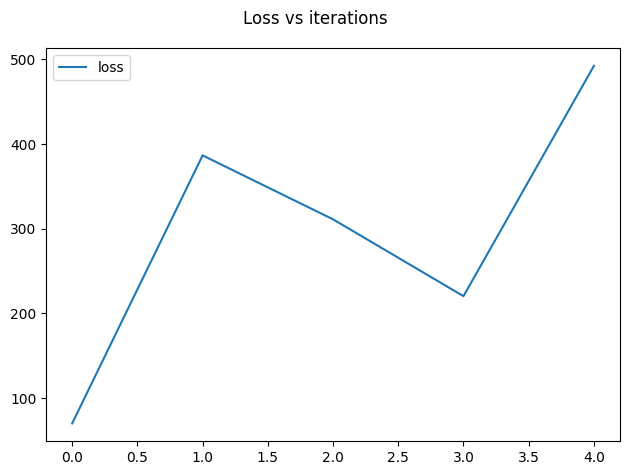

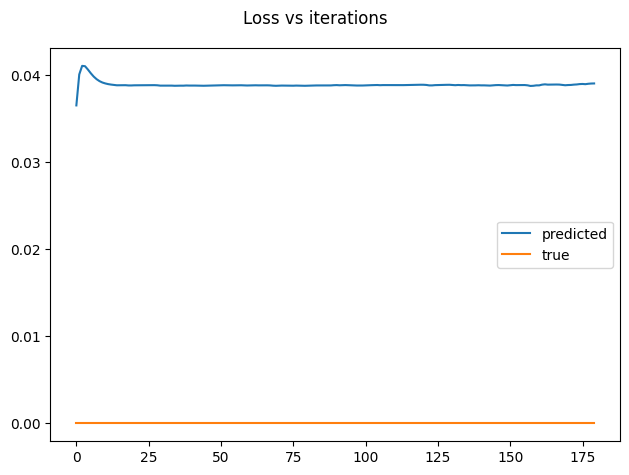

Epoch 0:   0%|          | 6/8038 [00:13<4:55:28,  2.21s/batch]

tensor(205.4498, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 6/8038 [00:15<4:55:28,  2.21s/batch]

tensor(259.3657, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 7/8038 [00:17<4:42:05,  2.11s/batch]

tensor(532.7847, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 8/8038 [00:19<4:41:31,  2.10s/batch]

tensor(771.3514, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 9/8038 [00:21<4:32:59,  2.04s/batch]

tensor(313.1578, grad_fn=<DivBackward0>)


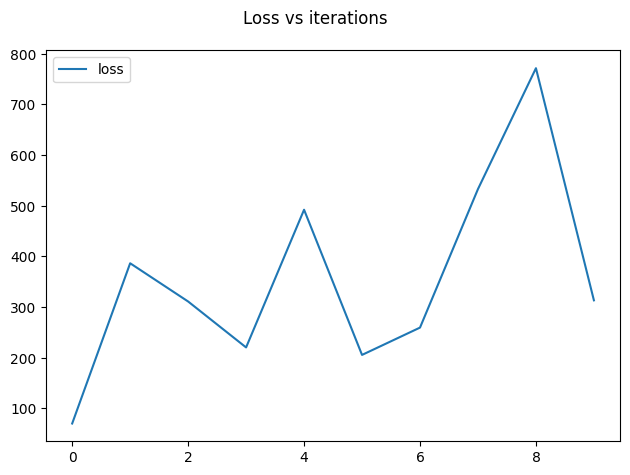

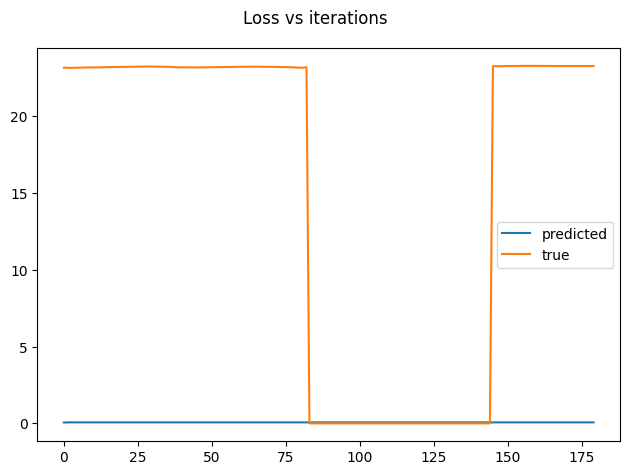

Epoch 0:   0%|          | 10/8038 [00:23<4:38:42,  2.08s/batch]

tensor(176.7213, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 11/8038 [00:25<4:27:56,  2.00s/batch]

tensor(419.8184, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 12/8038 [00:26<4:19:42,  1.94s/batch]

tensor(198.5153, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 13/8038 [00:28<4:18:00,  1.93s/batch]

tensor(324.3361, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 14/8038 [00:30<4:12:49,  1.89s/batch]

tensor(301.6923, grad_fn=<DivBackward0>)


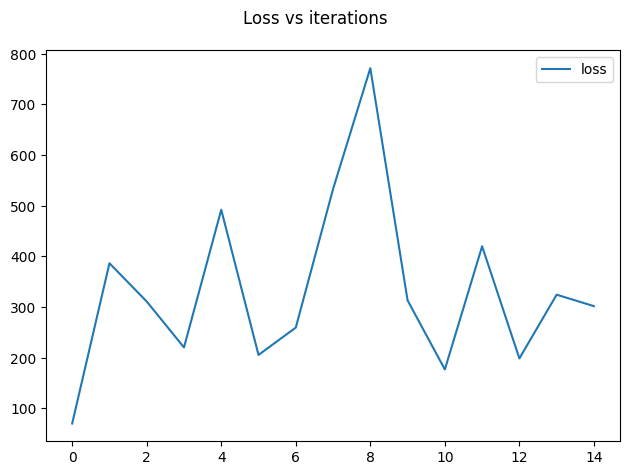

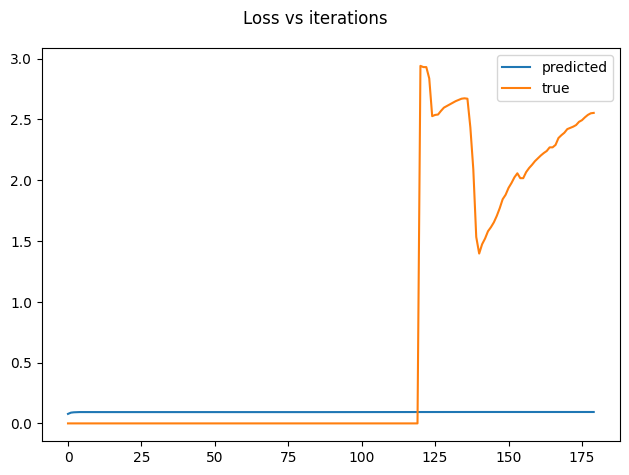

Epoch 0:   0%|          | 15/8038 [00:32<4:29:30,  2.02s/batch]

tensor(364.7701, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 16/8038 [00:34<4:24:19,  1.98s/batch]

tensor(123.8750, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 17/8038 [00:36<4:17:27,  1.93s/batch]

tensor(624.5745, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 18/8038 [00:38<4:16:18,  1.92s/batch]

tensor(458.1876, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 19/8038 [00:40<4:11:29,  1.88s/batch]

tensor(689.2694, grad_fn=<DivBackward0>)


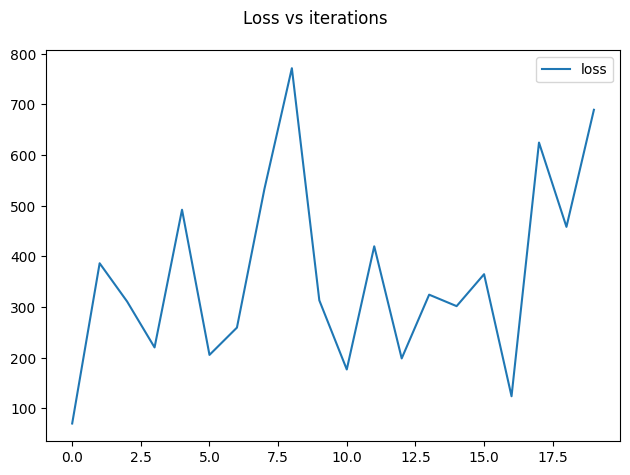

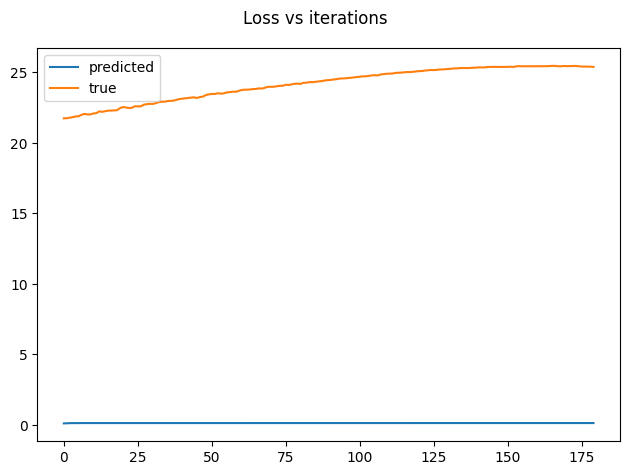

Epoch 0:   0%|          | 20/8038 [00:42<4:22:49,  1.97s/batch]

tensor(260.7507, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 21/8038 [00:44<4:21:40,  1.96s/batch]

tensor(442.3126, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 22/8038 [00:46<4:23:04,  1.97s/batch]

tensor(419.6760, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 23/8038 [00:48<4:28:36,  2.01s/batch]

tensor(199.8332, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 24/8038 [00:50<4:28:02,  2.01s/batch]

tensor(281.1573, grad_fn=<DivBackward0>)


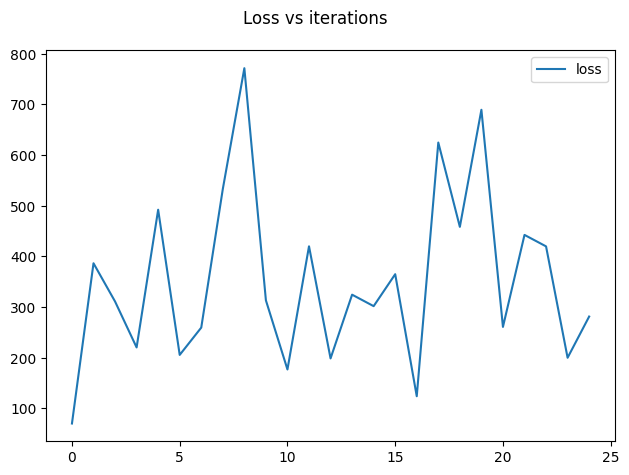

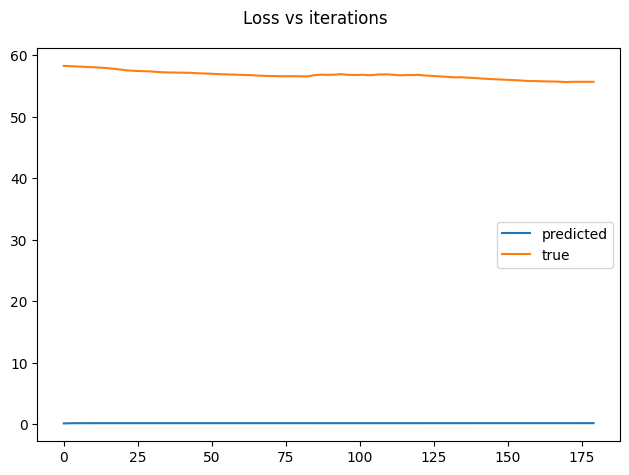

Epoch 0:   0%|          | 25/8038 [00:52<4:34:56,  2.06s/batch]

tensor(334.2747, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 26/8038 [00:54<4:25:14,  1.99s/batch]

tensor(368.3665, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 28/8038 [00:56<4:08:44,  1.86s/batch]

tensor(201.3178, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 28/8038 [00:58<4:08:44,  1.86s/batch]

tensor(407.7754, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 29/8038 [01:00<4:22:00,  1.96s/batch]

tensor(643.1112, grad_fn=<DivBackward0>)


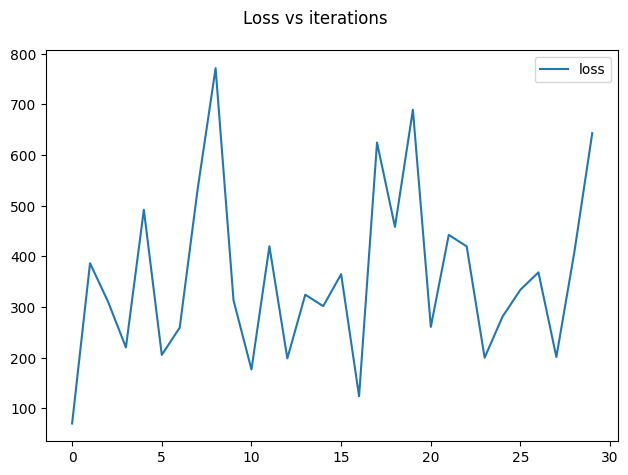

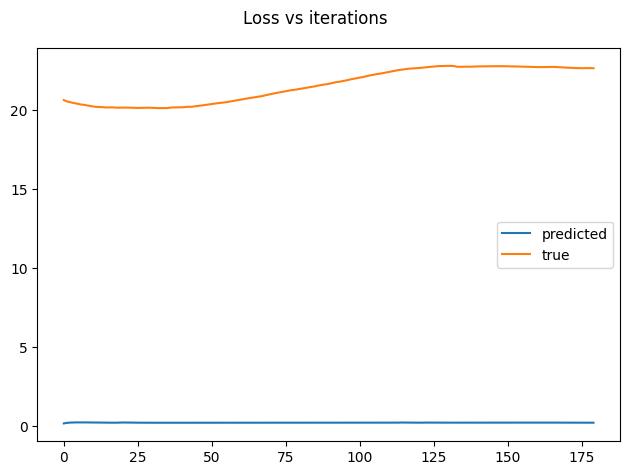

Epoch 0:   0%|          | 30/8038 [01:02<4:30:40,  2.03s/batch]

tensor(482.9035, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 31/8038 [01:04<4:26:00,  1.99s/batch]

tensor(279.1922, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 32/8038 [01:06<4:18:18,  1.94s/batch]

tensor(449.0614, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 33/8038 [01:08<4:24:49,  1.98s/batch]

tensor(457.5312, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 34/8038 [01:10<4:21:41,  1.96s/batch]

tensor(159.1599, grad_fn=<DivBackward0>)


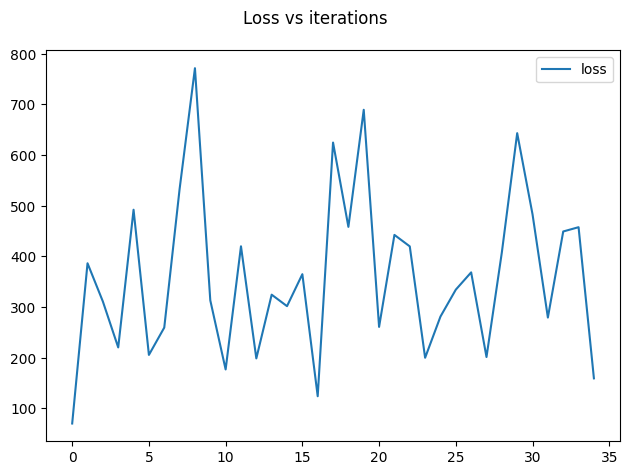

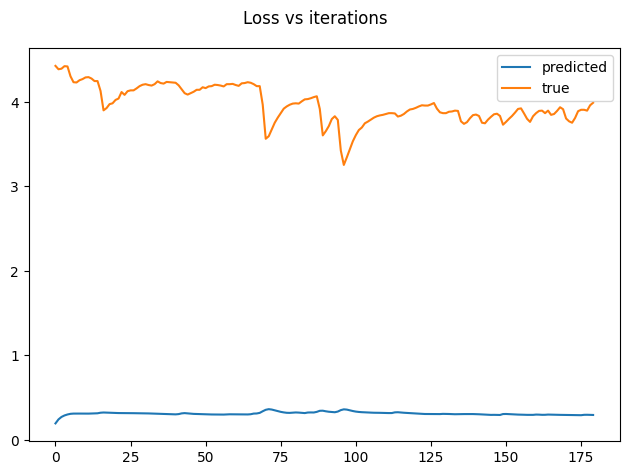

Epoch 0:   0%|          | 35/8038 [01:12<4:30:55,  2.03s/batch]

tensor(228.3168, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 36/8038 [01:14<4:21:52,  1.96s/batch]

tensor(293.7170, grad_fn=<DivBackward0>)


Epoch 0:   0%|          | 37/8038 [01:16<4:27:03,  2.00s/batch]

tensor(333.7065, grad_fn=<DivBackward0>)


: 

In [21]:
model.train()
start_time = time.time()
loss_list = []
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/runs"

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w, y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                z = z.to(device)
                w[0] = w[0].to(device)
                w[1] = w[1].to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w)
                loss = masked_mse(y_hat,
                                  y[:,:,0],
                                  y[:,:,1])
                print(loss)
                loss_list.append(loss.detach().numpy())

                
                loss.backward()
                optimizer.step()
            
                if (batch_idx+1)%1000 == 0:
                    plot_loss(np.arange(len(loss_list)),
                          np.array(loss_list),
                          save_dir = f"{save_dir}/loss_{timestamp}")
                
                    plot_predictions(np.arange(180),
                                 y_hat = y_hat[-1,:].detach().numpy(),
                                 y = y[-1,:,0].detach().numpy(),
                                 save_dir= f"{save_dir}/pred_{timestamp}")
                    
                
end_time = time.time()

# Sketches

In [36]:
input = torch.randn(1,10,1, 9, 12)
m = nn.Conv3d(10,10,(1,2,2))
m2 = nn.AdaptiveAvgPool3d((None,4,4))
lstm = nn.LSTM(10, 5, 1)
output = m(input)
for i in range(9):
    output = m(output)
output = m2(output)
output = m(output)
output = m(output)
output = m(output)
output = output.squeeze()
output = torch.moveaxis(output, (0, -1), (1, 0))
output = lstm(output)

output[0].size()

torch.Size([3, 30, 5])